In [1]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2
import os
import numpy as np
import time
import sklearn.preprocessing
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import pylab as pl

from maze_utils import *
from behav_utils import *
from ms_utils import *

mice_status = pd.read_excel("mice_maze_metadataAng.xlsx", sheet_name=0)
mice_names = mice_status["name"].values
data = pd.read_excel("mice_maze_metadataAng.xlsx", sheet_name=2)
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('img'):
    os.makedirs('img')

In [2]:
# Loop over mice_name, maze_type and training_day
for mice_name in mice_names:
    # maze_type_set = set(data[data.name == mice_name]["maze_type"])
    maze_type_set = {1}
    
    for maze_type in maze_type_set:
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])

        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            print(current_sign)
            
            folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
            print(folder)
            
            matfile = folder.values[0] + "/" + "ms.mat"
            # read calcium data: ms.mat
            with h5py.File(matfile, 'r') as f:
                ms_mat = f['ms']
                FiltTraces = np.array(ms_mat['FiltTraces'])
                RawTraces = np.array(ms_mat['RawTraces'])
                DeconvSignal = np.array(ms_mat['DeconvSignals'])
                ms_time = np.array(ms_mat['time'])[0,]
            # read behav data
            decision_file = 'data/' + current_sign +'behav_decision.pkl'
            with open(decision_file, 'rb') as handle:
                correct_time, wrong_time, correct_time_percentage, decision_rate,time_levels, stop_time_mean, stop_time_median, speed_bin = pickle.load(handle)
            behav_processed_file = 'data/' + current_sign +'behav_processed.pkl'
            with open(behav_processed_file, 'rb') as handle:
                behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)

            #### Preprocessing data
            # remove no behav recording period
            behav_mask = (ms_time>=behav_time_original[0]) & (ms_time<behav_time_original[-1])
            FiltTraces_behav = FiltTraces[:,behav_mask]
            RawTraces_behav = RawTraces[:,behav_mask]
            DeconvSignal_behav = DeconvSignal[:,behav_mask]
            ms_time_behav = ms_time[behav_mask]
            # binarize neuron.S
            deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
            Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)

            #### Incorporate maze structure to behavior trajectory: interpolation, etc..
            # transform bin number, making upper right bin (1, 1)
            nx = 12
            ny = 12
            graph = maze1_graph if maze_type==1 else maze2_graph
            total_bin = nx*ny
            start_node = 1
            end_node = 144
            test_maze = Maze(nx, ny, graph)
            new_maze = test_maze.make_maze()
            # new_maze = test_maze.make_maze() # no need to make_maze, already included in __init__()
            shortest_path = test_maze.BFS_SP(graph, start_node, end_node)

            #### Analyze calcium data
            # spike per bin
            spike_nodes = np.zeros_like(Spikes[0,:])
            for i in range(0, len(spike_nodes)):
                if ms_time_behav[i] < behav_time_original[0]:
                    spike_nodes[i] = start_node;
                else:
                    match_index = np.where(behav_time_original <= ms_time_behav[i])[0][-1]
                    spike_nodes[i] = behav_nodes_interpolated[match_index]
            spike_bins = test_maze.idx_to_loc(spike_nodes-1)

            # occupancy map, in ms
            # Duration for each (X,Y) sample (clipped to maxGap)
            maxGap = 100
            stay_time = np.append(np.ediff1d(ms_time_behav),0)
            stay_time[stay_time>maxGap] = maxGap
            _nbins = total_bin
            _coords_range = [0, _nbins +0.0001 ]
            occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
                    spike_nodes,
                    stay_time,
                    bins=_nbins,
                    statistic="sum",
                    range=_coords_range)

            assert((bin_numbers == spike_nodes).all())
            minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
            occu_time[occu_time<minimum_occu_thres] = np.nan
            # rate map (for all neuron)
            _nbins = total_bin
            _coords_range = [0, _nbins +0.0001 ]
            n_neuron = Spikes.shape[0]
            spike_freq_all = np.zeros([n_neuron,total_bin])
            rate_map_all =  np.zeros_like(spike_freq_all)
            for i in range(n_neuron):
                spike_freq_all[i,] ,_ ,_= scipy.stats.binned_statistic(
                    spike_nodes,
                    Spikes[i,:],
                    bins=_nbins,
                    statistic="sum",
                    range=_coords_range)
                rate_map_all[i,] = spike_freq_all[i,]/(occu_time/1000+ 1E-9)

            #### Calculate spatial information (all neurons) and shuffle (shift method)
            t_total = np.nansum(occu_time)/1000 # total time of trial
            t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time
            SI_all = np.zeros(n_neuron)
            is_placecell_shift = np.zeros(n_neuron)
            for i in tqdm(range(n_neuron)):
                SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
                is_placecell_shift[i] = shuffle_test_shift(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)    
            print("# of place cell using time shift shuffle method:" ,np.sum(is_placecell_shift ),"/",n_neuron)

            ## !! save data
            mylist = [rate_map_all, is_placecell_shift, SI_all, spike_freq_all, occu_time]
            with open('data/' + current_sign + "ratemap.pkl", 'wb') as f:
                pickle.dump(mylist, f)


            #### run selective %
            ## spike node to runs
            spike_runs = np.zeros_like(spike_nodes)
            for i in range(len(spike_nodes)):
                spike_runs[i] = node_to_run(spike_nodes[i], test_maze.runs)

            ## occupancy map, in ms
            _nruns = len(test_maze.runs)
            _coords_range = [0, _nruns +0.0001 ]
            occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
                    spike_runs,
                    stay_time,
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
            assert((run_numbers == spike_runs).all())
            minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
            occu_time_run[occu_time_run<minimum_occu_thres] = np.nan

            ## run rate map 
            ## sum rate map (for first neuron)
            spikes = Spikes[0,:]
            # spike_map: total spikes per nodes
            spike_freq_run, xbin_edges, run_numbers = scipy.stats.binned_statistic(
                    spike_runs,
                    spikes,
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
            rate_map_run = spike_freq_run/(occu_time_run/1000+ 1E-6) # ratemap: spike_map / occupancy_map
            assert((run_numbers == spike_runs).all())

            ## rate map for runs (for all neuron)
            n_neuron = Spikes.shape[0]
            spike_freq_run_all = np.zeros([n_neuron, _nruns])
            rate_map_run_all =  np.zeros_like(spike_freq_run_all)
            for i in range(n_neuron):
                spike_freq_run_all[i,] ,_ ,_= scipy.stats.binned_statistic(
                    spike_runs,
                    Spikes[i,:],
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
                rate_map_run_all[i,] = spike_freq_run_all[i,]/(occu_time_run/1000+ 1E-9)

            ## spatial information for runs(all neurons)
            t_runs_frac = occu_time_run/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

            # Shuffle: shift with a random constant
            SI_run_all = np.zeros(n_neuron)
            is_runcell_shift = np.zeros(n_neuron)

            for i in tqdm(range(n_neuron)):
                SI_run_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_run_all[i,], t_total=t_total, t_nodes_frac=t_runs_frac)
                is_runcell_shift[i] = shuffle_test_shift(SI = SI_run_all[i], spikes = Spikes[i,], spike_nodes=spike_runs, occu_time=occu_time_run, _coords_range=_coords_range, _nbins = _nruns)

            print("# of run cell using time shift shuffle method:", np.sum(is_runcell_shift), "/", n_neuron)

            ## !! save data
            mylist = [rate_map_run_all, is_runcell_shift, SI_run_all, spike_freq_run_all, occu_time_run]
            with open('data/' + current_sign + "ratemap_run.pkl", 'wb') as f:
                pickle.dump(mylist, f)


M10019maze1Day1
0    Z:/miniscope_recording/maze/4_18_2020/10019H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf node
Node 25 is Leaf node
Shortest path =  1 13 14 26 2

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [02:29<00:00,  1.82s/it]


# of place cell using time shift shuffle method: 28.0 / 82


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [02:23<00:00,  1.74s/it]


# of run cell using time shift shuffle method: 21.0 / 82
M10019maze1Day2
1    Z:/miniscope_recording/maze/4_19_2020/10019H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:26<00:00,  1.67s/it]


# of place cell using time shift shuffle method: 31.0 / 52


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:22<00:00,  1.59s/it]


# of run cell using time shift shuffle method: 32.0 / 52
M10019maze1Day3
2    Z:/miniscope_recording/maze/4_20_2020/10019H21...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:52<00:07,  2.40s/it]D:\Research\exploration in maze\code\AllMice\ms_utils.py:10: RuntimeWarning: invalid value encountered in true_divide
  logArg = rate_map / mean_rate;
D:\Research\exploration in maze\code\AllMice\ms_utils.py:14: RuntimeWarning: invalid value encountered in double_scalars
  SI = IC / mean_rate; # spatial information (bits/spike)
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.40s/it]


# of place cell using time shift shuffle method: 20.0 / 25


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:57<00:00,  2.29s/it]


# of run cell using time shift shuffle method: 21.0 / 25
M10019maze1Day4
3    Z:/miniscope_recording/maze/4_21_2020/10019H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]


# of place cell using time shift shuffle method: 4.0 / 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]


# of run cell using time shift shuffle method: 4.0 / 30
M10019maze1Day5
4    Z:/miniscope_recording/maze/4_22_2020/10019H10...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:21<00:00,  2.09it/s]


# of place cell using time shift shuffle method: 19.0 / 45


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:20<00:00,  2.15it/s]


# of run cell using time shift shuffle method: 18.0 / 45
M10019maze1Day6
5    Z:/miniscope_recording/maze/4_23_2020/10019H10...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:34<00:00,  2.06it/s]


# of place cell using time shift shuffle method: 16.0 / 71


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:32<00:00,  2.16it/s]


# of run cell using time shift shuffle method: 12.0 / 71
M10019maze1Day7
6    Z:/miniscope_recording/maze/4_24_2020/10019H10...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:22<00:00,  1.60it/s]


# of place cell using time shift shuffle method: 28.0 / 131


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [01:18<00:00,  1.66it/s]


# of run cell using time shift shuffle method: 28.0 / 131
M10019maze1Day8
7    Z:/miniscope_recording/maze/4_25_2020/10019H10...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:50<00:00,  1.19it/s]


# of place cell using time shift shuffle method: 30.0 / 60


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:47<00:00,  1.26it/s]


# of run cell using time shift shuffle method: 15.0 / 60
M10021maze1Day1
16    Z:/miniscope_recording/maze/4_17_2020/10021H19...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:38<00:00,  5.11s/it]


# of place cell using time shift shuffle method: 24.0 / 31


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:32<00:00,  4.93s/it]


# of run cell using time shift shuffle method: 24.0 / 31
M10021maze1Day2
17    Z:/miniscope_recording/maze/4_18_2020/10021H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [01:00<00:00,  1.29s/it]


# of place cell using time shift shuffle method: 23.0 / 47


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:57<00:00,  1.22s/it]


# of run cell using time shift shuffle method: 22.0 / 47
M10021maze1Day3
18    Z:/miniscope_recording/maze/4_19_2020/10021_H1...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:28<00:00,  1.51it/s]


# of place cell using time shift shuffle method: 9.0 / 43


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:27<00:00,  1.57it/s]


# of run cell using time shift shuffle method: 7.0 / 43
M10021maze1Day4
19    Z:/miniscope_recording/maze/4_20_2020/10021H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [11:13<00:00,  2.75s/it]


# of place cell using time shift shuffle method: 7.0 / 245


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [10:52<00:00,  2.66s/it]


# of run cell using time shift shuffle method: 20.0 / 245
M10021maze1Day5
20    Z:/miniscope_recording/maze/4_21_2020/10021H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.27it/s]


# of place cell using time shift shuffle method: 5.0 / 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.35it/s]


# of run cell using time shift shuffle method: 1.0 / 21
M10021maze1Day6
21    Z:/miniscope_recording/maze/4_22_2020/10021H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


# of place cell using time shift shuffle method: 9.0 / 21


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.38it/s]


# of run cell using time shift shuffle method: 9.0 / 21
M10021maze1Day7
22    Z:/miniscope_recording/maze/4_23_2020/10021H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.79it/s]


# of place cell using time shift shuffle method: 0.0 / 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.80it/s]


# of run cell using time shift shuffle method: 0.0 / 7
M10021maze1Day8
23    Z:/miniscope_recording/maze/4_24_2020/10021H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.06it/s]


# of place cell using time shift shuffle method: 6.0 / 36


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.09it/s]


# of run cell using time shift shuffle method: 5.0 / 36
M10021maze1Day9
24    Z:/miniscope_recording/maze/4_25_2020/10021H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:11<00:00,  1.85it/s]


# of place cell using time shift shuffle method: 6.0 / 22


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:11<00:00,  1.90it/s]


# of run cell using time shift shuffle method: 7.0 / 22
M10023maze1Day1
25    Z:/miniscope_recording/maze/4_17_2020/10023H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:40<00:00,  1.93s/it]


# of place cell using time shift shuffle method: 16.0 / 52


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:38<00:00,  1.89s/it]


# of run cell using time shift shuffle method: 9.0 / 52
M10023maze1Day2
26    Z:/miniscope_recording/maze/4_18_2020/10023H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [02:07<00:00,  2.49s/it]


# of place cell using time shift shuffle method: 13.0 / 51


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [02:04<00:00,  2.44s/it]


# of run cell using time shift shuffle method: 15.0 / 51
M10023maze1Day3
27    Z:/miniscope_recording/maze/4_19_2020/10023_H1...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:43<00:00,  1.03s/it]


# of place cell using time shift shuffle method: 12.0 / 42


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:41<00:00,  1.02it/s]


# of run cell using time shift shuffle method: 13.0 / 42
M10023maze1Day4
28    Z:/miniscope_recording/maze/4_20_2020/10023H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:05<00:00,  1.17it/s]


# of place cell using time shift shuffle method: 18.0 / 76


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:03<00:00,  1.20it/s]


# of run cell using time shift shuffle method: 26.0 / 76
M10023maze1Day5
29    Z:/miniscope_recording/maze/4_21_2020/10023H19...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:13<00:00,  1.39s/it]


# of place cell using time shift shuffle method: 42.0 / 53


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:12<00:00,  1.37s/it]


# of run cell using time shift shuffle method: 37.0 / 53
M10023maze1Day6
30    Z:/miniscope_recording/maze/4_22_2020/10023H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [02:10<00:00,  2.33s/it]


# of place cell using time shift shuffle method: 48.0 / 56


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [02:04<00:00,  2.23s/it]


# of run cell using time shift shuffle method: 46.0 / 56
M10023maze1Day7
31    Z:/miniscope_recording/maze/4_23_2020/10023H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


# of place cell using time shift shuffle method: 8.0 / 29


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


# of run cell using time shift shuffle method: 8.0 / 29
M10023maze1Day8
32    Z:/miniscope_recording/maze/4_24_2020/10023H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.08it/s]


# of place cell using time shift shuffle method: 12.0 / 39


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.11it/s]


# of run cell using time shift shuffle method: 12.0 / 39
M10023maze1Day9
33    Z:/miniscope_recording/maze/4_25_2020/10023H11...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:12<00:00,  1.05it/s]


# of place cell using time shift shuffle method: 41.0 / 76


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [01:10<00:00,  1.08it/s]


# of run cell using time shift shuffle method: 21.0 / 76
M10024maze1Day1
42    Z:/miniscope_recording/maze/4_17_2020/10024H13...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [01:27<00:00,  1.81s/it]


# of place cell using time shift shuffle method: 5.0 / 48


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [01:26<00:00,  1.79s/it]


# of run cell using time shift shuffle method: 6.0 / 48
M10024maze1Day2
43    Z:/miniscope_recording/maze/4_18_2020/10024H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:08<00:00,  2.15s/it]


# of place cell using time shift shuffle method: 25.0 / 60


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:04<00:00,  2.07s/it]


# of run cell using time shift shuffle method: 17.0 / 60
M10024maze1Day3
44    Z:/miniscope_recording/maze/4_19_2020/10024H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:50<00:00,  1.30it/s]


# of place cell using time shift shuffle method: 12.0 / 66


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:49<00:00,  1.33it/s]


# of run cell using time shift shuffle method: 17.0 / 66
M10024maze1Day4
45    Z:/miniscope_recording/maze/4_20_2020/10024H20...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


# of place cell using time shift shuffle method: 26.0 / 50


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


# of run cell using time shift shuffle method: 11.0 / 50
M10024maze1Day5
46    Z:/miniscope_recording/maze/4_21_2020/10024H19...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [01:23<00:00,  1.19s/it]


# of place cell using time shift shuffle method: 24.0 / 70


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [01:20<00:00,  1.16s/it]


# of run cell using time shift shuffle method: 11.0 / 70
M10024maze1Day6
47    Z:/miniscope_recording/maze/4_22_2020/10024H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [01:03<00:00,  1.03it/s]


# of place cell using time shift shuffle method: 36.0 / 66


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [01:01<00:00,  1.07it/s]


# of run cell using time shift shuffle method: 22.0 / 66
M10024maze1Day7
48    Z:/miniscope_recording/maze/4_23_2020/10024H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [01:02<00:00,  1.02s/it]


# of place cell using time shift shuffle method: 27.0 / 61


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:59<00:00,  1.02it/s]


# of run cell using time shift shuffle method: 17.0 / 61
M10024maze1Day8
49    Z:/miniscope_recording/maze/4_24_2020/10024H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:25<00:00,  1.62it/s]


# of place cell using time shift shuffle method: 13.0 / 41


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:24<00:00,  1.65it/s]


# of run cell using time shift shuffle method: 9.0 / 41
M10024maze1Day9
50    Z:/miniscope_recording/maze/4_25_2020/10024H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  3.10it/s]


# of place cell using time shift shuffle method: 4.0 / 38


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:12<00:00,  3.10it/s]


# of run cell using time shift shuffle method: 2.0 / 38
M10026maze1Day1
59    Z:/miniscope_recording/maze/4_17_2020/10026H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [03:53<00:00,  4.96s/it]


# of place cell using time shift shuffle method: 36.0 / 47


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [03:43<00:00,  4.76s/it]


# of run cell using time shift shuffle method: 25.0 / 47
M10026maze1Day2
60    Z:/miniscope_recording/maze/4_18_2020/10026H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:42<00:00,  1.30it/s]


# of place cell using time shift shuffle method: 21.0 / 56


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:42<00:00,  1.33it/s]


# of run cell using time shift shuffle method: 25.0 / 56
M10026maze1Day3
61    Z:/miniscope_recording/maze/4_19_2020/10026H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:21<00:00,  1.82it/s]


# of place cell using time shift shuffle method: 9.0 / 39


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:21<00:00,  1.83it/s]


# of run cell using time shift shuffle method: 8.0 / 39
M10026maze1Day4
62    Z:/miniscope_recording/maze/4_20_2020/10026H19...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


# of place cell using time shift shuffle method: 7.0 / 29


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


# of run cell using time shift shuffle method: 6.0 / 29
M10026maze1Day5
63    Z:/miniscope_recording/maze/4_21_2020/10026H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.08it/s]


# of place cell using time shift shuffle method: 1.0 / 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.06it/s]


# of run cell using time shift shuffle method: 2.0 / 15
M10026maze1Day6
64    Z:/miniscope_recording/maze/4_22_2020/10026H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:27<00:00,  1.24it/s]


# of place cell using time shift shuffle method: 22.0 / 34


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:26<00:00,  1.28it/s]


# of run cell using time shift shuffle method: 14.0 / 34
M10026maze1Day7
65    Z:/miniscope_recording/maze/4_23_2020/10026H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:15<00:00,  2.40it/s]


# of place cell using time shift shuffle method: 7.0 / 36


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:14<00:00,  2.41it/s]


# of run cell using time shift shuffle method: 5.0 / 36
M10026maze1Day8
66    Z:/miniscope_recording/maze/4_24_2020/10026H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s]


# of place cell using time shift shuffle method: 3.0 / 17


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s]


# of run cell using time shift shuffle method: 1.0 / 17
M10026maze1Day9
67    Z:/miniscope_recording/maze/4_25_2020/10026H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.46it/s]


# of place cell using time shift shuffle method: 2.0 / 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]


# of run cell using time shift shuffle method: 2.0 / 7
M10027maze1Day1
68    Z:/miniscope_recording/maze/4_17_2020/10027H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:14<00:00,  7.48s/it]


# of place cell using time shift shuffle method: 8.0 / 18


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [02:15<00:00,  7.54s/it]


# of run cell using time shift shuffle method: 7.0 / 18
M10027maze1Day2
69    Z:/miniscope_recording/maze/4_18_2020/10027H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:47<00:00,  1.40s/it]


# of place cell using time shift shuffle method: 21.0 / 34


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:46<00:00,  1.36s/it]


# of run cell using time shift shuffle method: 23.0 / 34
M10027maze1Day3
70    Z:/miniscope_recording/maze/4_19_2020/10027H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.32it/s]


# of place cell using time shift shuffle method: 3.0 / 28


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.31it/s]


# of run cell using time shift shuffle method: 1.0 / 28
M10027maze1Day4
71    Z:/miniscope_recording/maze/4_20_2020/10027H19...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:41<00:00,  1.14s/it]


# of place cell using time shift shuffle method: 9.0 / 36


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:39<00:00,  1.11s/it]


# of run cell using time shift shuffle method: 5.0 / 36
M10027maze1Day5
72    Z:/miniscope_recording/maze/4_21_2020/10027H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.74it/s]


# of place cell using time shift shuffle method: 3.0 / 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


# of run cell using time shift shuffle method: 5.0 / 30
M10027maze1Day6
73    Z:/miniscope_recording/maze/4_22_2020/10027H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


# of place cell using time shift shuffle method: 2.0 / 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


# of run cell using time shift shuffle method: 2.0 / 15
M10027maze1Day7
74    Z:/miniscope_recording/maze/4_23_2020/10027H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.62it/s]


# of place cell using time shift shuffle method: 3.0 / 17


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.61it/s]


# of run cell using time shift shuffle method: 2.0 / 17
M10027maze1Day8
75    Z:/miniscope_recording/maze/4_24_2020/10027H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


# of place cell using time shift shuffle method: 0.0 / 14


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.05it/s]


# of run cell using time shift shuffle method: 0.0 / 14
M10027maze1Day9
76    Z:/miniscope_recording/maze/4_25_2020/10027H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.46it/s]


# of place cell using time shift shuffle method: 1.0 / 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.35it/s]


# of run cell using time shift shuffle method: 0.0 / 7
M10028maze1Day1
77    Z:/miniscope_recording/maze/4_17_2020/10028H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Leaf

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [02:13<00:00,  3.26s/it]


# of place cell using time shift shuffle method: 16.0 / 41


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [02:10<00:00,  3.19s/it]


# of run cell using time shift shuffle method: 13.0 / 41
M10028maze1Day2
78    Z:/miniscope_recording/maze/4_18_2020/10028H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:11<00:00,  1.35s/it]


# of place cell using time shift shuffle method: 24.0 / 53


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [01:10<00:00,  1.33s/it]


# of run cell using time shift shuffle method: 24.0 / 53
M10028maze1Day3
79    Z:/miniscope_recording/maze/4_19_2020/10028H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:58<00:00,  1.32s/it]


# of place cell using time shift shuffle method: 21.0 / 44


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:56<00:00,  1.28s/it]


# of run cell using time shift shuffle method: 19.0 / 44
M10028maze1Day4
80    Z:/miniscope_recording/maze/4_20_2020/10028H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:30<00:00,  2.07it/s]


# of place cell using time shift shuffle method: 10.0 / 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:30<00:00,  2.07it/s]


# of run cell using time shift shuffle method: 6.0 / 64
M10028maze1Day5
81    Z:/miniscope_recording/maze/4_21_2020/10028H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:59<00:00,  1.17it/s]


# of place cell using time shift shuffle method: 29.0 / 69


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:58<00:00,  1.19it/s]


# of run cell using time shift shuffle method: 24.0 / 69
M10028maze1Day6
82    Z:/miniscope_recording/maze/4_22_2020/10028H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:16<00:00,  3.20it/s]


# of place cell using time shift shuffle method: 5.0 / 52


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:17<00:00,  3.02it/s]


# of run cell using time shift shuffle method: 4.0 / 52
M10028maze1Day7
83    Z:/miniscope_recording/maze/4_23_2020/10028H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:33<00:00,  2.23it/s]


# of place cell using time shift shuffle method: 18.0 / 75


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:33<00:00,  2.22it/s]


# of run cell using time shift shuffle method: 9.0 / 75
M10028maze1Day8
84    Z:/miniscope_recording/maze/4_24_2020/10028H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:23<00:00,  2.55it/s]


# of place cell using time shift shuffle method: 9.0 / 61


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:24<00:00,  2.48it/s]


# of run cell using time shift shuffle method: 5.0 / 61
M10028maze1Day9
85    Z:/miniscope_recording/maze/4_25_2020/10028H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:10<00:00,  3.71it/s]


# of place cell using time shift shuffle method: 4.0 / 39


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.44it/s]


# of run cell using time shift shuffle method: 0.0 / 39
M10030maze1Day1
94    Z:/miniscope_recording/maze/4_17_2020/10030H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [05:49<00:00,  3.46s/it]


# of place cell using time shift shuffle method: 62.0 / 101


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [05:36<00:00,  3.33s/it]


# of run cell using time shift shuffle method: 58.0 / 101
M10030maze1Day2
95    Z:/miniscope_recording/maze/4_18_2020/10030H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:16<00:00,  1.10it/s]


# of place cell using time shift shuffle method: 31.0 / 84


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [01:15<00:00,  1.12it/s]


# of run cell using time shift shuffle method: 31.0 / 84
M10030maze1Day3
96    Z:/miniscope_recording/maze/4_19_2020/10030H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [02:12<00:00,  1.22s/it]


# of place cell using time shift shuffle method: 88.0 / 109


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [02:13<00:00,  1.23s/it]


# of run cell using time shift shuffle method: 77.0 / 109
M10030maze1Day4
97    Z:/miniscope_recording/maze/4_20_2020/10030H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [01:52<00:00,  1.35s/it]


# of place cell using time shift shuffle method: 55.0 / 83


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [01:49<00:00,  1.31s/it]


# of run cell using time shift shuffle method: 37.0 / 83
M10030maze1Day5
98    Z:/miniscope_recording/maze/4_21_2020/10030H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [02:29<00:00,  2.23s/it]


# of place cell using time shift shuffle method: 63.0 / 67


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [02:24<00:00,  2.16s/it]


# of run cell using time shift shuffle method: 52.0 / 67
M10030maze1Day6
99    Z:/miniscope_recording/maze/4_22_2020/10030H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.09s/it]


# of place cell using time shift shuffle method: 13.0 / 15


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.06s/it]


# of run cell using time shift shuffle method: 12.0 / 15
M10030maze1Day7
100    Z:/miniscope_recording/maze/4_23_2020/10030H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.27it/s]


# of place cell using time shift shuffle method: 4.0 / 54


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:24<00:00,  2.22it/s]


# of run cell using time shift shuffle method: 8.0 / 54
M10030maze1Day8
101    Z:/miniscope_recording/maze/4_24_2020/10030H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:49<00:00,  1.22it/s]


# of place cell using time shift shuffle method: 26.0 / 60


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:48<00:00,  1.24it/s]


# of run cell using time shift shuffle method: 19.0 / 60
M10030maze1Day9
102    Z:/miniscope_recording/maze/4_25_2020/10030H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.74it/s]


# of place cell using time shift shuffle method: 3.0 / 38


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.62it/s]


# of run cell using time shift shuffle method: 2.0 / 38
M10031maze1Day1
128    Z:/miniscope_recording/maze/4_18_2020/10031H13...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:27<00:00,  3.94s/it]


# of place cell using time shift shuffle method: 101.0 / 144


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:14<00:00,  3.85s/it]


# of run cell using time shift shuffle method: 96.0 / 144
M10031maze1Day2
129    Z:/miniscope_recording/maze/4_19_2020/10031H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is 

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [02:10<00:00,  1.03it/s]


# of place cell using time shift shuffle method: 39.0 / 135


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [02:07<00:00,  1.06it/s]


# of run cell using time shift shuffle method: 32.0 / 135
M10031maze1Day3
130    Z:/miniscope_recording/maze/4_20_2020/10031H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is 

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [05:26<00:00,  1.98s/it]


# of place cell using time shift shuffle method: 46.0 / 165


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [05:27<00:00,  1.98s/it]


# of run cell using time shift shuffle method: 55.0 / 165
M10031maze1Day4
131    Z:/miniscope_recording/maze/4_21_2020/10031H17...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is 

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:56<00:00,  1.51it/s]


# of place cell using time shift shuffle method: 6.0 / 85


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:57<00:00,  1.49it/s]


# of run cell using time shift shuffle method: 12.0 / 85
M10031maze1Day5
132    Z:/miniscope_recording/maze/4_22_2020/10031H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


# of place cell using time shift shuffle method: 75.0 / 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


# of run cell using time shift shuffle method: 64.0 / 100
M10031maze1Day6
133    Z:/miniscope_recording/maze/4_23_2020/10031H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is 

100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [01:17<00:00,  1.37it/s]


# of place cell using time shift shuffle method: 16.0 / 106


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [01:17<00:00,  1.36it/s]


# of run cell using time shift shuffle method: 13.0 / 106
M10031maze1Day7
134    Z:/miniscope_recording/maze/4_24_2020/10031H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is 

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:36<00:00,  1.88it/s]


# of place cell using time shift shuffle method: 13.0 / 69


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:37<00:00,  1.85it/s]


# of run cell using time shift shuffle method: 11.0 / 69
M10031maze1Day8
135    Z:/miniscope_recording/maze/4_25_2020/10031H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:14<00:00,  1.21it/s]


# of place cell using time shift shuffle method: 55.0 / 90


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:13<00:00,  1.22it/s]


# of run cell using time shift shuffle method: 48.0 / 90
M10032maze1Day1
111    Z:/miniscope_recording/maze/4_17_2020/10032H18...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [04:05<00:00,  3.41s/it]


# of place cell using time shift shuffle method: 48.0 / 72


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [04:00<00:00,  3.34s/it]


# of run cell using time shift shuffle method: 41.0 / 72
M10032maze1Day2
112    Z:/miniscope_recording/maze/4_18_2020/10032H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:26<00:00,  1.20s/it]


# of place cell using time shift shuffle method: 50.0 / 72


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:26<00:00,  1.20s/it]


# of run cell using time shift shuffle method: 39.0 / 72
M10032maze1Day3
113    Z:/miniscope_recording/maze/4_19_2020/10032H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [01:23<00:00,  1.19s/it]


# of place cell using time shift shuffle method: 45.0 / 70


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [01:22<00:00,  1.17s/it]


# of run cell using time shift shuffle method: 27.0 / 70
M10032maze1Day4
114    Z:/miniscope_recording/maze/4_20_2020/10032H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:07<00:00,  1.18it/s]


# of place cell using time shift shuffle method: 62.0 / 80


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:07<00:00,  1.19it/s]


# of run cell using time shift shuffle method: 28.0 / 80
M10032maze1Day5
115    Z:/miniscope_recording/maze/4_21_2020/10032H16...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:53<00:00,  1.62it/s]


# of place cell using time shift shuffle method: 32.0 / 87


100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:53<00:00,  1.62it/s]


# of run cell using time shift shuffle method: 18.0 / 87
M10032maze1Day6
116    Z:/miniscope_recording/maze/4_22_2020/10032H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:11<00:00,  3.49it/s]


# of place cell using time shift shuffle method: 5.0 / 39


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:12<00:00,  3.22it/s]


# of run cell using time shift shuffle method: 5.0 / 39
M10032maze1Day7
117    Z:/miniscope_recording/maze/4_23_2020/10032H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:15<00:00,  3.60it/s]


# of place cell using time shift shuffle method: 3.0 / 55


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.28it/s]


# of run cell using time shift shuffle method: 1.0 / 55
M10032maze1Day8
118    Z:/miniscope_recording/maze/4_24_2020/10032H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:23<00:00,  3.87it/s]


# of place cell using time shift shuffle method: 9.0 / 92


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:26<00:00,  3.49it/s]


# of run cell using time shift shuffle method: 6.0 / 92
M10032maze1Day9
119    Z:/miniscope_recording/maze/4_25_2020/10032H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.84it/s]


# of place cell using time shift shuffle method: 4.0 / 31


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.45it/s]


# of run cell using time shift shuffle method: 3.0 / 31
M10033maze1Day1
144    Z:/miniscope_recording/maze/4_18_2020/10033H12...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [03:24<00:00,  4.36s/it]


# of place cell using time shift shuffle method: 23.0 / 47


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [03:19<00:00,  4.24s/it]


# of run cell using time shift shuffle method: 22.0 / 47
M10033maze1Day2
145    Z:/miniscope_recording/maze/4_19_2020/10033H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is L

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


# of place cell using time shift shuffle method: 0.0 / 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


# of run cell using time shift shuffle method: 0.0 / 3
M10033maze1Day3
146    Z:/miniscope_recording/maze/4_20_2020/10033H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Lea

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.20it/s]


# of place cell using time shift shuffle method: 2.0 / 22


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.20it/s]


# of run cell using time shift shuffle method: 1.0 / 22
M10033maze1Day4
147    Z:/miniscope_recording/maze/4_21_2020/10033H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.23it/s]


# of place cell using time shift shuffle method: 1.0 / 19


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.22it/s]


# of run cell using time shift shuffle method: 1.0 / 19
M10033maze1Day5
148    Z:/miniscope_recording/maze/4_22_2020/10033H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.25it/s]


# of place cell using time shift shuffle method: 2.0 / 11


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.24it/s]


# of run cell using time shift shuffle method: 0.0 / 11
M10033maze1Day6
149    Z:/miniscope_recording/maze/4_23_2020/10033H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  1.98it/s]


# of place cell using time shift shuffle method: 1.0 / 23


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.92it/s]


# of run cell using time shift shuffle method: 0.0 / 23
M10033maze1Day7
150    Z:/miniscope_recording/maze/4_24_2020/10033H14...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


# of place cell using time shift shuffle method: 0.0 / 29


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


# of run cell using time shift shuffle method: 1.0 / 29
M10033maze1Day8
151    Z:/miniscope_recording/maze/4_25_2020/10033H15...
Name: recording_folder_local, dtype: object
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is Leaf node
Node 143 is Leaf node
Node 135 is Leaf node
Node 52 is Leaf node
Node 93 is Leaf node
Node 96 is Leaf node
Node 35 is Leaf node
Node 41 is Le

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.79it/s]


# of place cell using time shift shuffle method: 0.0 / 20


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]

# of run cell using time shift shuffle method: 1.0 / 20


In [3]:
SI_all = np.zeros(n_neuron)
is_placecell_shift = np.zeros(n_neuron)

for i in tqdm(range(n_neuron)):
    SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
    is_placecell_shift[i] = shuffle_test_shift(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [09:05<00:00,  3.79s/it]


In [6]:
print("# of place cell using time shift shuffle method:" ,np.sum(is_placecell_shift ),"/",n_neuron)
# print("# of place cell using time all shuffle method:", np.sum(is_placecell_all ))
print("# of place cell using time isi shuffle method:", np.sum(is_placecell_isi ),"/",n_neuron)


# of place cell using time shift shuffle method: 99.0 / 144
# of place cell using time isi shuffle method: 135.0 / 144


In [14]:
# plot ratemap 2d:
# sorted by place cell first
sort_by_place_cell = True
filename = 'img_tmp/'+current_sign+'ratemap.pdf'
# Sort by score if desired
if sort_by_place_cell:
    ordering = np.argsort(-np.array(is_placecell_shift))
else:
    ordering = range(n_neuron)
# Plot
cols = 8
rows = int(np.ceil(n_neuron / cols))
fig = plt.figure(figsize=(24, rows * 4))
for i in range(n_neuron):
    rf = plt.subplot(rows * 2, cols, i + 1)
    if i < n_neuron:
        index = ordering[i]
        title = "%d (%.2f)" % (index, SI_all[index])
        # Plot maze
        # test_maze.maze_plot(axes = axes)
        # Plot the activation maps
        if is_placecell_shift[index] == 1:
            title = title+" PlaceCell"
            plot_ratemap(np.reshape(rate_map_all[index,], [12,12]), axes=rf, title=title)
        else:
            plot_ratemap(np.reshape(rate_map_all[index,], [12,12]), axes=rf, title=title)
        # pl.colorbar()
        rf.invert_yaxis()

with PdfPages(filename, "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)


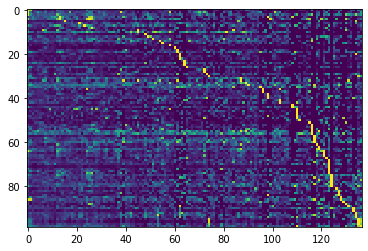

In [84]:
# plot ratemap 1d (all place cells):
sort_by_nodes = True
num_pc = int(sum(is_placecell_shift))
rate_map_pc= rate_map_all[is_placecell_shift==1,]
place_fields = np.nanargmax(rate_map_pc,axis=1)+1 # place field

if sort_by_nodes:
    ordering = np.argsort(np.nanargmax(rate_map_pc,axis=1))
else:
    ordering = range(num_pc)

# normalize tuning curve to [0, 1]
rate_map_pc_norm = sklearn.preprocessing.minmax_scale(rate_map_pc, feature_range=(0, 1), axis=1, copy=True)
# plot
plot_ratemap(rate_map_pc_norm[ordering,:][:,~np.isnan(rate_map_pc_norm[0,])])
filename = 'img_tmp/'+current_sign+'_normratemap_1d.pdf'
with PdfPages(filename, "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

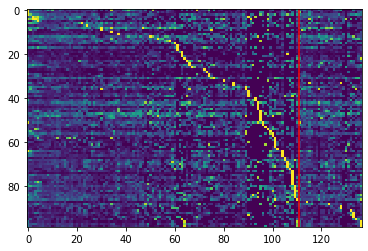

In [85]:
# ratemap 1d: orderd by shortest path
sort_by_path = True
num_pc = int(sum(is_placecell_shift))
rate_map_pc= rate_map_all[is_placecell_shift==1,]
len_shortest_path = len(test_maze.shortest_path)
if sort_by_path:
    non_shortest_path = list(np.setdiff1d(list(graph.keys()), test_maze.shortest_path))  
    preferred_nodes = np.nanargmax(rate_map_pc,axis=1)+1 # place field
    total_list = shortest_path + non_shortest_path
    tmp_index = np.zeros(num_pc)
    for i in range(num_pc):
        tmp_index[i] =  np.where(total_list == preferred_nodes[i])[0]
        
    ordering = np.argsort(tmp_index)
else:
    ordering = range(num_pc)

# normalize tuning curve to [0, 1]
rate_map_pc_norm = sklearn.preprocessing.minmax_scale(rate_map_pc, feature_range=(0, 1), axis=1, copy=True)
plt.axvline(len_shortest_path, color = "red")
# plot
rate_map_ordered = rate_map_pc_norm[ordering,:][:,np.array(total_list)-1]
plot_ratemap(rate_map_ordered[:,~np.isnan(rate_map_ordered[0,])])
# save figure
filename = 'img_tmp/'+current_sign+'_normratemap_1d.pdf'
with PdfPages(filename, "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

In [17]:
# shortest path selective %
path_prefer_num = 0
for i in range(num_pc):
    if place_fields[i] in shortest_path:
        path_prefer_num += 1
        
path_ratio = path_prefer_num/num_pc
path_ratio_chance = len(shortest_path)/total_bin
print("% of place fields on shortest path： " + "{:.2f}".format(path_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(path_ratio_chance*100)+"%" )


% of place fields on shortest path： 87.88%
 Chance Level: 77.08%


In [18]:
# decision node selective %
decision_prefer_num = 0
for i in range(num_pc):
    if place_fields[i] in test_maze.decision_nodes:
        decision_prefer_num += 1
        
decision_ratio = decision_prefer_num/num_pc
decision_ratio_chance = len(test_maze.decision_nodes)/total_bin
print("% of place fields on decison nodes： " + "{:.2f}".format(decision_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(decision_ratio_chance*100)+"%" )


% of place fields on decison nodes： 13.13%
 Chance Level: 11.81%


In [19]:
# run selective %
## spike node to runs
spike_runs = np.zeros_like(spike_nodes)
for i in range(len(spike_nodes)):
    spike_runs[i] = [run_i for run_i, run in enumerate(test_maze.runs) if spike_nodes[i] in run][0] +1

# occupancy map, in ms
_nruns = len(test_maze.runs)
_coords_range = [0, _nruns +0.0001 ]
occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        stay_time,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
assert((run_numbers == spike_runs).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time_run[occu_time_run<minimum_occu_thres] = np.nan

# run rate map 
### sum rate map (for first neuron)
spikes = Spikes[0,:]
# spike_map: total spikes per nodes
spike_freq_run, xbin_edges, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        spikes,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
rate_map_run = spike_freq_run/(occu_time_run/1000+ 1E-6) # ratemap: spike_map / occupancy_map
assert((run_numbers == spike_runs).all())

# rate map for runs (for all neuron)
n_neuron = Spikes.shape[0]
spike_freq_run_all = np.zeros([n_neuron, _nruns])
rate_map_run_all =  np.zeros_like(spike_freq_run_all)
for i in range(n_neuron):
    spike_freq_run_all[i,] ,_ ,_= scipy.stats.binned_statistic(
        spike_runs,
        Spikes[i,:],
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
    rate_map_run_all[i,] = spike_freq_run_all[i,]/(occu_time_run/1000+ 1E-9)

In [21]:
# spatial information for runs(all neurons)
t_runs_frac = occu_time_run/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

# Shuffle ISI: DOI: 10.1523/JNEUROSCI.19-21-09497.1999
SI_run_all = np.zeros(n_neuron)
is_runcell_isi = np.zeros(n_neuron)

for i in tqdm(range(n_neuron)):
    SI_run_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_run_all[i,], t_total=t_total, t_nodes_frac=t_runs_frac)
    is_runcell_isi[i] = shuffle_test_shift(SI = SI_run_all[i], spikes = Spikes[i,], spike_nodes=spike_runs, occu_time=occu_time_run, _coords_range=_coords_range, _nbins = _nruns)
    
print("# of run cell using time isi shuffle method:", np.sum(is_runcell_isi ))


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [08:47<00:00,  3.67s/it]

# of run cell using time isi shuffle method: 94.0


In [3]:
# plot ratemap 1d (all run cells):
sort_by_nodes = True
num_rc = int(sum(is_runcell_isi))
rate_map_rc= rate_map_run_all[is_runcell_isi==1,]
run_fields = np.nanargmax(rate_map_rc,axis=1) # run field

if sort_by_nodes:
    ordering = np.argsort(np.nanargmax(rate_map_rc,axis=1))
else:
    ordering = range(num_rc)

# normalize tuning curve to [0, 1]
rate_map_rc_norm = sklearn.preprocessing.minmax_scale(rate_map_rc, feature_range=(0, 1), axis=1, copy=True)
# plot
plot_ratemap(rate_map_rc_norm[ordering,:][:,~np.isnan(rate_map_rc_norm[0,])],extent = [0 , 1000, 0 , 300])
# save figure
filename = 'img_tmp/'+current_sign+'_normratemap_run_1d.pdf'

with PdfPages(filename, "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

NameError: name 'is_runcell_isi' is not defined

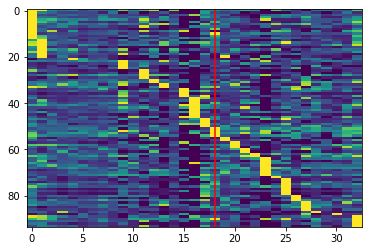

In [88]:
# run ratemap 1d: orderd by shortest path
sort_by_path = True
num_rc = int(sum(is_runcell_isi))
rate_map_rc= rate_map_run_all[is_runcell_isi==1,]
run_fields = np.nanargmax(rate_map_rc,axis=1) # place field
run_ind = np.arange(len(test_maze.runs))

if sort_by_path:
    run_on_path = [test_maze.runs[i_run][0] in test_maze.shortest_path for i_run in range(_nruns)]
    len_shortest_path_run = sum(run_on_path)
    on_path_runs = run_ind[run_on_path]
    non_shortest_path = list(np.setdiff1d(list(run_ind),on_path_runs))
    preferred_runs = np.nanargmax(rate_map_rc,axis=1) # run field
    total_list = list(on_path_runs) + non_shortest_path
    tmp_index = np.zeros(num_rc)
    for i in range(num_rc):
        tmp_index[i] =  np.where(total_list == preferred_runs[i])[0]
        
    ordering = np.argsort(tmp_index)
else:
    ordering = range(num_rc)

# normalize tuning curve to [0, 1]
rate_map_rc_norm = sklearn.preprocessing.minmax_scale(rate_map_rc, feature_range=(0, 1), axis=1, copy=True)
# plot
rate_map_rc_ordered = rate_map_rc_norm[ordering,:][:,np.array(total_list)]
plot_ratemap(rate_map_rc_ordered[:,~np.isnan(rate_map_rc_ordered[0,])])
plt.axvline(len_shortest_path_run, color = "red")

# save figure
filename = 'img_tmp/'+current_sign+'_normratemap_run_1d_path.pdf'

with PdfPages(filename, "w") as f:
    plt.savefig(f, format="pdf")
    plt.close(fig)

In [89]:
# percent of run filed on shortest path

num_shortpath_runfield = np.sum([preferred_run in on_path_runs for preferred_run in preferred_runs])
run_path_ratio = num_shortpath_runfield/num_rc
run_path_ratio_chance = np.sum(run_on_path)/len(test_maze.runs)
print("% of run fields on shortest path： " + "{:.2f}".format(run_path_ratio*100) + "%\n Chance Level: " + "{:.2f}".format(run_path_ratio_chance*100)+"%" )


% of run fields on shortest path： 54.26%
 Chance Level: 51.43%


In [78]:
def plot_ratemap(ratemap, ax=None, title=None, axis_on = True, *args, **kwargs):  # pylint: disable=keyword-arg-before-vararg
    """Plot ratemaps."""
    if ax is None:
        ax = plt.gca()
    # Plot the ratemap
    ax.imshow(ratemap, interpolation='none', *args, **kwargs)
    # ax.pcolormesh(ratemap, *args, **kwargs)
    if axis_on == False:
        ax.axis('off')
    else:
        ax.axis('auto')
    if title is not None:
        ax.set_title(title)


In [45]:
len(test_maze.shortest_path)

111

In [92]:
np.nansum(occu_time_run)/1000

1988.84

In [96]:
(ms_time_behav[-1]-ms_time_behav[0])/1000

1998.621

In [97]:
1998/60

33.3

In [26]:
max(spike_runs)

35

In [4]:
folder

6    E:/miniscope recording/maze/4_24_2020/10031H15...
Name: recording_folder_pc, dtype: object

In [5]:
    current_day = 8
    current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
    folder =  data[(data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_pc"]
    matfile = folder.values[0] + "/" + "ms.mat"
    # read calcium data: ms.mat
    with h5py.File(matfile, 'r') as f:
        ms_mat = f['ms']
        FiltTraces = np.array(ms_mat['FiltTraces'])
        RawTraces = np.array(ms_mat['RawTraces'])
        DeconvSignal = np.array(ms_mat['DeconvSignals'])
        ms_time = np.array(ms_mat['time'])[0,]
    # read behav data


In [7]:
#### read data
current_day = 8
current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
folder =  data[(data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_pc"]
matfile = folder.values[0] + "/" + "ms.mat"
# read calcium data: ms.mat
with h5py.File(matfile, 'r') as f:
    ms_mat = f['ms']
    FiltTraces = np.array(ms_mat['FiltTraces'])
    RawTraces = np.array(ms_mat['RawTraces'])
    DeconvSignal = np.array(ms_mat['DeconvSignals'])
    ms_time = np.array(ms_mat['time'])[0,]
# read behav data
graph = maze1_graph
decision_file = 'data_tmp/' + current_sign +'behav_decision.pkl'
with open(decision_file, 'rb') as handle:
    correct_time, wrong_time, correct_time_percentage, decision_rate,time_levels = pickle.load(handle)
behav_processed_file = 'data_tmp/' + current_sign +'behav_processed.pkl'
with open(behav_processed_file, 'rb') as handle:
    behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)

#### Preprocessing data
# remove no behav recording period
behav_mask = (ms_time>=behav_time_original[0]) & (ms_time<behav_time_original[-1])
FiltTraces_behav = FiltTraces[:,behav_mask]
RawTraces_behav = RawTraces[:,behav_mask]
DeconvSignal_behav = DeconvSignal[:,behav_mask]
ms_time_behav = ms_time[behav_mask]
# binarize neuron.S
deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)

#### Initialize maze object
start_node = 1
end_node = 144
nx = 12
ny = 12
total_bin = nx*ny
test_maze = Maze(nx, ny, graph)
new_maze = test_maze.make_maze()
shortest_path = test_maze.BFS_SP(graph, start_node, end_node)

#### Analyze calcium data
# spike per bin
spike_nodes = np.zeros_like(Spikes[0,:])
for i in range(0, len(spike_nodes)):
    if ms_time_behav[i] < behav_time_original[0]:
        spike_nodes[i] = start_node;
    else:
        match_index = np.where(behav_time_original <= ms_time_behav[i])[0][-1]
        spike_nodes[i] = behav_nodes_interpolated[match_index]
spike_bins = test_maze.idx_to_loc(spike_nodes-1)

# occupancy map, in ms
# Duration for each (X,Y) sample (clipped to maxGap)
maxGap = 100
stay_time = np.append(np.ediff1d(ms_time_behav),0)
stay_time[stay_time>maxGap] = maxGap
_nbins = total_bin
_coords_range = [0, _nbins +0.0001 ]
occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
        spike_nodes,
        stay_time,
        bins=_nbins,
        statistic="sum",
        range=_coords_range)

assert((bin_numbers == spike_nodes).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time[occu_time<minimum_occu_thres] = np.nan
# rate map (for all neuron)
_nbins = total_bin
_coords_range = [0, _nbins +0.0001 ]
n_neuron = Spikes.shape[0]
spike_freq_all = np.zeros([n_neuron,total_bin])
rate_map_all =  np.zeros_like(spike_freq_all)
for i in range(n_neuron):
    spike_freq_all[i,] ,_ ,_= scipy.stats.binned_statistic(
        spike_nodes,
        Spikes[i,:],
        bins=_nbins,
        statistic="sum",
        range=_coords_range)
    rate_map_all[i,] = spike_freq_all[i,]/(occu_time/1000+ 1E-9)

#### Calculate spatial information (all neurons) and shuffle (shift method)
t_total = np.nansum(occu_time)/1000 # total time of trial
t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time
SI_all = np.zeros(n_neuron)
is_placecell_shift = np.zeros(n_neuron)
for i in tqdm(range(n_neuron)):
    SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
    is_placecell_shift[i] = shuffle_test_shift(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)    
print("# of place cell using time shift shuffle method:" ,np.sum(is_placecell_shift ),"/",n_neuron)

## !! save data
mylist = [rate_map_all, is_placecell_shift, SI_all, spike_freq_all, occu_time]
with open('data/' + current_sign + "ratemap.pkl", 'wb') as f:
    pickle.dump(mylist, f)


#### run selective %
## spike node to runs
spike_runs = np.zeros_like(spike_nodes)
for i in range(len(spike_nodes)):
    spike_runs[i] = [run_i for run_i, run in enumerate(test_maze.runs) if spike_nodes[i] in run][0] +1

## occupancy map, in ms
_nruns = len(test_maze.runs)
_coords_range = [0, _nruns +0.0001 ]
occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        stay_time,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
assert((run_numbers == spike_runs).all())
minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
occu_time_run[occu_time_run<minimum_occu_thres] = np.nan

## run rate map 
## sum rate map (for first neuron)
spikes = Spikes[0,:]
# spike_map: total spikes per nodes
spike_freq_run, xbin_edges, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        spikes,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
rate_map_run = spike_freq_run/(occu_time_run/1000+ 1E-6) # ratemap: spike_map / occupancy_map
assert((run_numbers == spike_runs).all())

## rate map for runs (for all neuron)
n_neuron = Spikes.shape[0]
spike_freq_run_all = np.zeros([n_neuron, _nruns])
rate_map_run_all =  np.zeros_like(spike_freq_run_all)
for i in range(n_neuron):
    spike_freq_run_all[i,] ,_ ,_= scipy.stats.binned_statistic(
        spike_runs,
        Spikes[i,:],
        bins=_nruns,
        statistic="sum",
        range=_coords_range)
    rate_map_run_all[i,] = spike_freq_run_all[i,]/(occu_time_run/1000+ 1E-9)

## spatial information for runs(all neurons)
t_runs_frac = occu_time_run/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

# Shuffle: shift with a random constant
SI_run_all = np.zeros(n_neuron)
is_runcell_shift = np.zeros(n_neuron)

for i in tqdm(range(n_neuron)):
    SI_run_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_run_all[i,], t_total=t_total, t_nodes_frac=t_runs_frac)
    is_runcell_shift[i] = shuffle_test_shift(SI = SI_run_all[i], spikes = Spikes[i,], spike_nodes=spike_runs, occu_time=occu_time_run, _coords_range=_coords_range, _nbins = _nruns)

print("# of run cell using time shift shuffle method:", np.sum(is_runcell_shift))

## !! save data
mylist = [rate_map_run_all, is_runcell_shift, SI_run_all, spike_freq_run_all, occu_time_run]
with open('data_tmp/' + current_sign + "ratemap_run.pkl", 'wb') as f:
    pickle.dump(mylist, f)


  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

The maze is bidirectional, Ye!


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:10<00:00,  1.27it/s]


# of place cell using time shift shuffle method: 57.0 / 90


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [01:07<00:00,  1.33it/s]

# of run cell using time shift shuffle method: 43.0


In [19]:
rate_map_run_all[8]

array([0.        , 0.        , 0.11980352, 0.12044202, 0.79554495,
       0.10990219, 0.        , 0.        , 0.0607054 , 0.59526172,
       0.        , 0.64319022, 2.96208531, 4.66355763, 0.        ,
       0.49710025, 0.        , 0.8097166 , 0.        , 0.        ,
       0.87227414, 0.07298205, 0.        , 0.        , 0.        ,
              nan, 0.34277879, 0.        , 0.56896981, 0.        ,
       1.42207053, 0.        , 1.60889279, 0.        , 0.        ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [12]:
rate_map_all[1,]

array([0.26838433, 0.        , 0.34025179, 0.        , 0.        ,
       0.        , 0.96618357, 1.5015015 , 0.        , 0.        ,
       0.        , 0.        , 0.11980352, 1.0653882 , 1.02880658,
       0.52714813, 0.        , 0.26357406, 0.78926598, 1.20076849,
       0.        , 0.        , 0.41067762, 0.45495905, 0.        ,
       0.27905679, 0.89746466, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.20521239, 1.00014288, 0.57714506, 1.32538105, 1.6194332 ,
              nan, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 3.01034807, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.46253469,
       0.        , 0.95785441, 3.03030303, 0.        , 0.        ,
       0.68135362, 0.        , 0.        , 0.        , 0.        ,
       0.88495575, 0.        , 0.        , 0.        , 0.        ,
       2.61096605, 0.        , 0.69300069, 0.        , 0.     

In [10]:
len(test_maze.runs)

70

In [11]:
test_maze.runs

[[1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
  60,
  59,
  58,
  57,
  56,
  68,
  69,
  70,
  71,
  72,
  84],
 [83, 95, 94],
 [82, 81, 80, 92, 104, 103, 91, 90, 78, 79, 67, 55],
 [43],
 [54],
 [53],
 [66, 65, 64, 63, 75, 74, 62, 50, 51],
 [39],
 [40],
 [38, 37, 49, 61, 73, 85, 97],
 [98, 86],
 [109],
 [110,
  122,
  123,
  111,
  112,
  100,
  99,
  87,
  88,
  76,
  77,
  89,
  101,
  102,
  114,
  113,
  125,
  124,
  136,
  137,
  138,
  126,
  127,
  115,
  116,
  117,
  129],
 [128, 140, 139],
 [141, 142],
 [130],
 [118, 119, 107, 108, 120],
 [131, 132, 144],
 [143],
 [121, 133, 134, 135],
 [52],
 [106, 105, 93],
 [96],
 [36, 35],
 [42, 41],
 [25],
 [1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
 

In [21]:
min(stay_time)

0.0

In [22]:
occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
        spike_runs,
        stay_time,
        bins=_nruns,
        statistic="sum",
        range=_coords_range)

In [27]:
occu_time_run.shape

(70,)

In [28]:
len(test_maze.runs)

70

In [29]:
test_maze.runs

[[1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
  60,
  59,
  58,
  57,
  56,
  68,
  69,
  70,
  71,
  72,
  84],
 [83, 95, 94],
 [82, 81, 80, 92, 104, 103, 91, 90, 78, 79, 67, 55],
 [43],
 [54],
 [53],
 [66, 65, 64, 63, 75, 74, 62, 50, 51],
 [39],
 [40],
 [38, 37, 49, 61, 73, 85, 97],
 [98, 86],
 [109],
 [110,
  122,
  123,
  111,
  112,
  100,
  99,
  87,
  88,
  76,
  77,
  89,
  101,
  102,
  114,
  113,
  125,
  124,
  136,
  137,
  138,
  126,
  127,
  115,
  116,
  117,
  129],
 [128, 140, 139],
 [141, 142],
 [130],
 [118, 119, 107, 108, 120],
 [131, 132, 144],
 [143],
 [121, 133, 134, 135],
 [52],
 [106, 105, 93],
 [96],
 [36, 35],
 [42, 41],
 [25],
 [1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
 

In [9]:
#### Initialize maze object
start_node = 1
end_node = 144
nx = 12
ny = 12
total_bin = nx*ny
graph = maze1_graph
test_maze = Maze(nx, ny, graph)
print(len(test_maze.runs))


The maze is bidirectional, Ye!
0


In [7]:
new_maze = test_maze.make_maze()
len(test_maze.runs)

0

In [29]:
test_maze.runs

NameError: name 'test_maze' is not defined

In [8]:
test_maze.runs

[[1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
  60,
  59,
  58,
  57,
  56,
  68,
  69,
  70,
  71,
  72,
  84],
 [83, 95, 94],
 [82, 81, 80, 92, 104, 103, 91, 90, 78, 79, 67, 55],
 [43],
 [54],
 [53],
 [66, 65, 64, 63, 75, 74, 62, 50, 51],
 [39],
 [40],
 [38, 37, 49, 61, 73, 85, 97],
 [98, 86],
 [109],
 [110,
  122,
  123,
  111,
  112,
  100,
  99,
  87,
  88,
  76,
  77,
  89,
  101,
  102,
  114,
  113,
  125,
  124,
  136,
  137,
  138,
  126,
  127,
  115,
  116,
  117,
  129],
 [128, 140, 139],
 [141, 142],
 [130],
 [118, 119, 107, 108, 120],
 [131, 132, 144],
 [143],
 [121, 133, 134, 135],
 [52],
 [106, 105, 93],
 [96],
 [36, 35],
 [42, 41],
 [25],
 [1],
 [2],
 [13],
 [14, 26, 27, 15, 3, 4, 5, 6],
 [7, 8],
 [18, 17],
 [16, 28],
 [29, 30],
 [31, 19, 20, 21, 9, 10, 11, 12, 24],
 [23,
  22,
  34,
  33,
  32,
  44,
  45,
  46,
  47,
  48,
 

In [2]:
len(test_maze.runs)

0

In [5]:
import h5py
mice_names = mice_status["name"]
mice_names = mice_names.drop(4)
# maze_type_mice = set(data[data.name == mice_names[0]]["maze_type"])
maze_type_set = set(data[data.name == mice_name]["maze_type"])
training_day_set = set(data[(data.name == mice_names[0]) & (data.maze_type == 1)]["training_day"])
for mice_name in mice_names:
    maze_type_set = set(data[data.name == mice_name]["maze_type"])

    for maze_type in maze_type_set:
        # training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            
            folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
            matfile = folder.values[0] + "/" + "ms.mat"
            with h5py.File(matfile, 'r') as f:
                ms_mat = f['ms']
                if(len(ms_mat)!=28):
                    print(current_sign)
                    print(folder)
                    print("ms data length:",len(ms_mat))


M10019maze2Day3
10    Z:/miniscope_recording/maze/4_30_2020/10019H14...
Name: recording_folder_local, dtype: object
ms data length: 26
M10024maze1Day8
49    Z:/miniscope_recording/maze/4_24_2020/10024H17...
Name: recording_folder_local, dtype: object
ms data length: 27
M10027maze1Day1
68    Z:/miniscope_recording/maze/4_17_2020/10027H15...
Name: recording_folder_local, dtype: object
ms data length: 26
M10031maze1Day3
130    Z:/miniscope_recording/maze/4_20_2020/10031H16...
Name: recording_folder_local, dtype: object
ms data length: 25
M10031maze1Day7
134    Z:/miniscope_recording/maze/4_24_2020/10031H15...
Name: recording_folder_local, dtype: object
ms data length: 27


In [12]:
mice_names = [10028,10030,10031,10032,10033]
# Loop over mice_name, maze_type and training_day
for mice_name in mice_names:
    # maze_type_set = set(data[data.name == mice_name]["maze_type"])
    maze_type_set = {1}
    
    for maze_type in maze_type_set:
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])

        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            print(current_sign)
            
            folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
            print(folder)
            
            matfile = folder.values[0] + "/" + "ms.mat"
            # read calcium data: ms.mat
            with h5py.File(matfile, 'r') as f:
                ms_mat = f['ms']
                FiltTraces = np.array(ms_mat['FiltTraces'])
                RawTraces = np.array(ms_mat['RawTraces'])
                DeconvSignal = np.array(ms_mat['DeconvSignals'])
                ms_time = np.array(ms_mat['time'])[0,]
            # read behav data
            decision_file = 'data/' + current_sign +'behav_decision.pkl'
            with open(decision_file, 'rb') as handle:
                correct_time, wrong_time, correct_time_percentage, decision_rate,time_levels, stop_time_mean, stop_time_median, speed_bin = pickle.load(handle)
            behav_processed_file = 'data/' + current_sign +'behav_processed.pkl'
            with open(behav_processed_file, 'rb') as handle:
                behav_time_original, behav_nodes_interpolated, behav_dir = pickle.load(handle)

            #### Preprocessing data
            # remove no behav recording period
            behav_mask = (ms_time>=behav_time_original[0]) & (ms_time<behav_time_original[-1])
            FiltTraces_behav = FiltTraces[:,behav_mask]
            RawTraces_behav = RawTraces[:,behav_mask]
            DeconvSignal_behav = DeconvSignal[:,behav_mask]
            ms_time_behav = ms_time[behav_mask]
            # binarize neuron.S
            deconv_sd = np.std(DeconvSignal_behav, axis = 1) * 3
            Spikes = np.where(DeconvSignal_behav>np.repeat(deconv_sd[:,np.newaxis], DeconvSignal_behav.shape[1],1), 1, 0)

            #### Incorporate maze structure to behavior trajectory: interpolation, etc..
            # transform bin number, making upper right bin (1, 1)
            nx = 12
            ny = 12
            graph = maze1_graph if maze_type==1 else maze2_graph
            total_bin = nx*ny
            start_node = 1
            end_node = 144
            test_maze = Maze(nx, ny, graph)
            new_maze = test_maze.make_maze()
            # new_maze = test_maze.make_maze() # no need to make_maze, already included in __init__()
            shortest_path = test_maze.BFS_SP(graph, start_node, end_node)

            #### Analyze calcium data
            # spike per bin
            spike_nodes = np.zeros_like(Spikes[0,:])
            for i in range(0, len(spike_nodes)):
                if ms_time_behav[i] < behav_time_original[0]:
                    spike_nodes[i] = start_node;
                else:
                    match_index = np.where(behav_time_original <= ms_time_behav[i])[0][-1]
                    spike_nodes[i] = behav_nodes_interpolated[match_index]
            spike_bins = test_maze.idx_to_loc(spike_nodes-1)

            # occupancy map, in ms
            # Duration for each (X,Y) sample (clipped to maxGap)
            maxGap = 100
            stay_time = np.append(np.ediff1d(ms_time_behav),0)
            stay_time[stay_time>maxGap] = maxGap
            _nbins = total_bin
            _coords_range = [0, _nbins +0.0001 ]
            occu_time, xbin_edges, bin_numbers = scipy.stats.binned_statistic(
                    spike_nodes,
                    stay_time,
                    bins=_nbins,
                    statistic="sum",
                    range=_coords_range)

            assert((bin_numbers == spike_nodes).all())
            minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
            occu_time[occu_time<minimum_occu_thres] = np.nan
            # rate map (for all neuron)
            _nbins = total_bin
            _coords_range = [0, _nbins +0.0001 ]
            n_neuron = Spikes.shape[0]
            spike_freq_all = np.zeros([n_neuron,total_bin])
            rate_map_all =  np.zeros_like(spike_freq_all)
            for i in range(n_neuron):
                spike_freq_all[i,] ,_ ,_= scipy.stats.binned_statistic(
                    spike_nodes,
                    Spikes[i,:],
                    bins=_nbins,
                    statistic="sum",
                    range=_coords_range)
                rate_map_all[i,] = spike_freq_all[i,]/(occu_time/1000+ 1E-9)

            #### Calculate spatial information (all neurons) and shuffle (shift method)
            t_total = np.nansum(occu_time)/1000 # total time of trial
            t_nodes_frac = occu_time/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time
            SI_all = np.zeros(n_neuron)
            is_placecell_shift = np.zeros(n_neuron)
            for i in tqdm(range(n_neuron)):
                SI_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_all[i,], t_total=t_total, t_nodes_frac=t_nodes_frac)
                is_placecell_shift[i] = shuffle_test_shift(SI = SI_all[i], spikes = Spikes[i,], spike_nodes=spike_nodes, occu_time=occu_time, _coords_range=_coords_range)    
            print("# of place cell using time shift shuffle method:" ,np.sum(is_placecell_shift ),"/",n_neuron)

            ## !! save data
            mylist = [rate_map_all, is_placecell_shift, SI_all, spike_freq_all, occu_time]
            with open('data/' + current_sign + "ratemap.pkl", 'wb') as f:
                pickle.dump(mylist, f)


            #### run selective %
            ## spike node to runs
            spike_runs = np.zeros_like(spike_nodes)
            for i in range(len(spike_nodes)):
                spike_runs[i] = node_to_run(spike_nodes[i], test_maze.runs)

            ## occupancy map, in ms
            _nruns = len(test_maze.runs)
            _coords_range = [0, _nruns +0.0001 ]
            occu_time_run, _, run_numbers = scipy.stats.binned_statistic(
                    spike_runs,
                    stay_time,
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
            assert((run_numbers == spike_runs).all())
            minimum_occu_thres = 50 # ms, occupancy time less than the threshold are set to NAN, preventing large spike rate
            occu_time_run[occu_time_run<minimum_occu_thres] = np.nan

            ## run rate map 
            ## sum rate map (for first neuron)
            spikes = Spikes[0,:]
            # spike_map: total spikes per nodes
            spike_freq_run, xbin_edges, run_numbers = scipy.stats.binned_statistic(
                    spike_runs,
                    spikes,
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
            rate_map_run = spike_freq_run/(occu_time_run/1000+ 1E-6) # ratemap: spike_map / occupancy_map
            assert((run_numbers == spike_runs).all())

            ## rate map for runs (for all neuron)
            n_neuron = Spikes.shape[0]
            spike_freq_run_all = np.zeros([n_neuron, _nruns])
            rate_map_run_all =  np.zeros_like(spike_freq_run_all)
            for i in range(n_neuron):
                spike_freq_run_all[i,] ,_ ,_= scipy.stats.binned_statistic(
                    spike_runs,
                    Spikes[i,:],
                    bins=_nruns,
                    statistic="sum",
                    range=_coords_range)
                rate_map_run_all[i,] = spike_freq_run_all[i,]/(occu_time_run/1000+ 1E-9)

            ## spatial information for runs(all neurons)
            t_runs_frac = occu_time_run/1000/ (t_total+ 1E-6)   # time spent in ith bin/total session time

            # Shuffle: shift with a random constant
            SI_run_all = np.zeros(n_neuron)
            is_runcell_shift = np.zeros(n_neuron)

            for i in tqdm(range(n_neuron)):
                SI_run_all[i] = calc_SI(spikes=Spikes[i,], rate_map=rate_map_run_all[i,], t_total=t_total, t_nodes_frac=t_runs_frac)
                is_runcell_shift[i] = shuffle_test_shift(SI = SI_run_all[i], spikes = Spikes[i,], spike_nodes=spike_runs, occu_time=occu_time_run, _coords_range=_coords_range, _nbins = _nruns)

            print("# of run cell using time shift shuffle method:", np.sum(is_runcell_shift), "/", n_neuron)

            ## !! save data
            mylist = [rate_map_run_all, is_runcell_shift, SI_run_all, spike_freq_run_all, occu_time_run]
            with open('data/' + current_sign + "ratemap_run.pkl", 'wb') as f:
                pickle.dump(mylist, f)


M10028maze1Day1
77    Z:/miniscope_recording/maze/4_17_2020/10028H16...
Name: recording_folder_local, dtype: object


FileNotFoundError: [Errno 2] No such file or directory: 'data/M10028maze1Day1behav_decision.pkl'

In [4]:
mice_names = ["10026","10027","10028","10030","10031","10032","10033"]
# Loop over mice_name, maze_type and training_day
for mice_name in mice_names:
    print(mice_name)


10026
10027
10028
10030
10031
10032
10033


In [10]:
data[data.name == 10026]

,name,training_day,maze_type,recording_folder,recording_folder_local,note
59,10026,1,1,H:\miniscope recording\maze\4_17_2020\10026H14...,Z:/miniscope_recording/maze/4_17_2020/10026H14...,NaN
60,10026,2,1,H:\miniscope recording\maze\4_18_2020\10026H14...,Z:/miniscope_recording/maze/4_18_2020/10026H14...,NaN
61,10026,3,1,H:\miniscope recording\maze\4_19_2020\10026H14...,Z:/miniscope_recording/maze/4_19_2020/10026H14...,NaN
62,10026,4,1,H:\miniscope recording\maze\4_20_2020\10026H19...,Z:/miniscope_recording/maze/4_20_2020/10026H19...,NaN
63,10026,5,1,H:\miniscope recording\maze\4_21_2020\10026H18...,Z:/miniscope_recording/maze/4_21_2020/10026H18...,NaN
64,10026,6,1,H:\miniscope recording\maze\4_22_2020\10026H16...,Z:/miniscope_recording/maze/4_22_2020/10026H16...,NaN
65,10026,7,1,H:\miniscope recording\maze\4_23_2020\10026H16...,Z:/miniscope_recording/maze/4_23_2020/10026H16...,NaN
66,10026,8,1,H:\miniscope recording\maze\4_24_2020\10026H16...,Z:/miniscope_recording/maze/4_24_2020/10026H16...,NaN
67,10026,9,1,H:\miniscope recording\maze\4_25_2020\10026H17...,Z:/miniscope_recording/maze/4_25_2020/10026H17...,NaN


In [7]:
data

,name,training_day,maze_type,recording_folder,recording_folder_local,note
0,10019,1,1,H:\miniscope recording\maze\4_18_2020\10019H16...,Z:/miniscope_recording/maze/4_18_2020/10019H16...,NaN
1,10019,2,1,H:\miniscope recording\maze\4_19_2020\10019H16...,Z:/miniscope_recording/maze/4_19_2020/10019H16...,NaN
2,10019,3,1,H:\miniscope recording\maze\4_20_2020\10019H21...,Z:/miniscope_recording/maze/4_20_2020/10019H21...,NaN
3,10019,4,1,H:\miniscope recording\maze\4_21_2020\10019H20...,Z:/miniscope_recording/maze/4_21_2020/10019H20...,NaN
4,10019,5,1,H:\miniscope recording\maze\4_22_2020\10019H10...,Z:/miniscope_recording/maze/4_22_2020/10019H10...,NaN
...,...,...,...,...,...,...
147,10033,4,1,H:\miniscope recording\maze\4_21_2020\10033H14...,Z:/miniscope_recording/maze/4_21_2020/10033H14...,NaN
148,10033,5,1,H:\miniscope recording\maze\4_22_2020\10033H14...,Z:/miniscope_recording/maze/4_22_2020/10033H14...,NaN
149,10033,6,1,H:\miniscope recording\maze\4_23_2020\10033H14...,Z:/miniscope_recording/maze/4_23_2020/10033H14...,NaN
150,10033,7,1,H:\miniscope recording\maze\4_24_2020\10033H14...,Z:/miniscope_recording/maze/4_24_2020/10033H14...,NaN
